# H-Feature Analysis
This is an optional notebook where we will go through the steps of creating random walks using the H-path method. These can be used as a feature when learning HAS-embeddings in the HAS_entity_embeddings notebook. We will do some analysis of what happens with different parameter choices as well as results of using the feature for learning embeddings.

*What is this feature?* --> These random walks are intended to detect similarity due to homophily. I.e. entities with similar neighbors are similar.

## Pre-requisite steps to run this notebook
1. You need to run the 1_candidate_label_creation notebook before this notebook.
2. gensim is a dependency. You can install it with `pip install --upgrade gensim`, or if you want to use Anaconda, `conda install -c conda-forge gensim`

In [1]:
import os
import random
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import graph_tool.all as gt
from kgtk.gt.gt_load import load_graph_from_kgtk
from kgtk.io.kgtkreader import KgtkReader
import pathlib
import matplotlib.pyplot as plt
from collections import Counter
from h_path_walks import gt_random_walks
import seaborn as sns

## parameters

**Embedding model parameters**   
*num_walks*: Number of random walks to start at each node with the H-feature walk method  
*walk_length*: Length of random walk started at each node  
*representation_size*: Number of latent dimensions to learn from each node  
*window_size*: Window size of skipgram model  
*workers*: Number of parallel processes  

**File/Directory parameters**  
*item_file*: File path for the file that contains entity to entity relationships (e.g. wikibase-item).  
*label_file*: File path for the file that contains wikidata labels.  
*work_dir*: same work_dir that you specified in the label creation notebook. Files created by this notebook will also be saved here.  
*store_dir*: Path to folder containing the sqlite3.db file that we will use for our queries. We will reuse an existing file if there is one in this folder. Otherwise we will create a new one.

In [2]:
# Embedding model params
num_walks = 10
walk_length = 10
representation_size = 64
window_size = 5
workers = 32

# File/Directory params
item_file = "../../Q44/data/Q44.part.wikibase-item.tsv"
label_file = "../../Q44/data/Q44.label.en.tsv"
work_dir = "../../Q44/profiler_work"
store_dir = "../../Q44"

# item_file = "../../Q154/data/parts/claims.wikibase-item.tsv.gz"
# label_file = "../../Q154/data/parts/labels.en.tsv.gz"
# work_dir = "../../Q154/profiler_work"
# store_dir = "../../Q154"

### Process parameters and set up variables / file names

In [3]:
# Ensure paths are absolute
item_file = os.path.abspath(item_file)
label_file = os.path.abspath(label_file)
work_dir = os.path.abspath(work_dir)
store_dir = os.path.abspath(store_dir)
    
# Create directories
if not os.path.exists(work_dir):
    os.makedirs(work_dir)
output_dir = "{}/H_walks_analysis".format(work_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Setting up environment variables 
os.environ['ITEM_FILE'] = item_file
os.environ['LABEL_FILE'] = label_file
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(store_dir)
os.environ['LABEL_CREATION'] = "{}/label_creation".format(work_dir)
os.environ['OUT'] = output_dir
os.environ['kgtk'] = "kgtk" # Need to do this for kgtk to be recognized as a command when passing it through a subprocess call

### Helpers

In [4]:
def plot_walk_length_dist(walks):
    print("Number of walks: {}".format(len(walks)))
    walk_lengths = [len(arr) for arr in walks]
    print("Number of walks of each length:")
    counts_str = ", ".join(["{} : {}".format(key,value) for key,value in sorted(Counter(walk_lengths).items())])
    print(counts_str)
    fig, ax = plt.subplots()
    ax.hist(walk_lengths,bins=np.arange(12)-.5)
    ax.set_ylabel('Number of walks')
    ax.set_xlabel('Walk length')
    plt.show()
    
def plot_distinct_nodes_in_walks(walks):
    print("Number of walks: {}".format(len(walks)))
    count_distinct_nodes = [len(set(arr)) for arr in walks]
    print("Number of walks by number of unique nodes visited:")
    counts_str = ", ".join(["{} : {}".format(key,value) for key,value in sorted(Counter(count_distinct_nodes).items())])
    print(counts_str)
    fig, ax = plt.subplots()
    ax.hist(count_distinct_nodes,bins=np.arange(12)-.5)
    ax.set_ylabel('Number of walks')
    ax.set_xlabel('Number of unique nodes visited')
    plt.show()

### 1. Loading entity to entity edges into a Graph-Tool graph
loading two versions to look at - one with directed edges and one with undirected edges. The default in the authors' code is undirected, though they do not mention if this is what they used for the results that they presented in the paper.

In [5]:
kr = KgtkReader.open(pathlib.Path(item_file))
g_directed = load_graph_from_kgtk(kr, directed=True, hashed=True)
kr = KgtkReader.open(pathlib.Path(item_file))
g_undirected = load_graph_from_kgtk(kr, directed=False, hashed=True)

In [6]:
print("This graph has {} vertices and {} edges".format(len(g_directed.get_vertices()), len(g_directed.get_edges())))

This graph has 11294 vertices and 20516 edges


### 2. Build corpus of random walks

**First for directed representation**

In [7]:
%%time
h_walks_directed = gt_random_walks(g_directed, walk_length, num_walks)

CPU times: user 5.69 s, sys: 61.8 ms, total: 5.75 s
Wall time: 5.75 s


Let's look at how many walks we have and how long they are (max walk length is 10).

Number of walks: 112940
Number of walks of each length:
1 : 109640, 2 : 2039, 3 : 940, 4 : 227, 5 : 75, 6 : 12, 7 : 3, 8 : 2, 9 : 1, 10 : 1


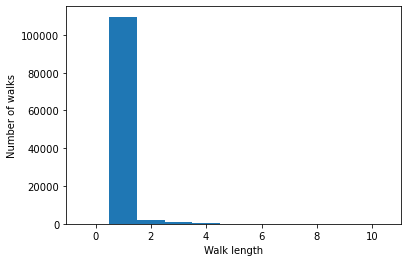

In [8]:
plot_walk_length_dist(h_walks_directed)

**Now for undirected representation**

In [9]:
%%time
h_walks_undirected = gt_random_walks(g_undirected, walk_length, num_walks)

CPU times: user 9.32 s, sys: 721 ms, total: 10 s
Wall time: 10.1 s


Number of walks: 112940
Number of walks of each length:
10 : 112940


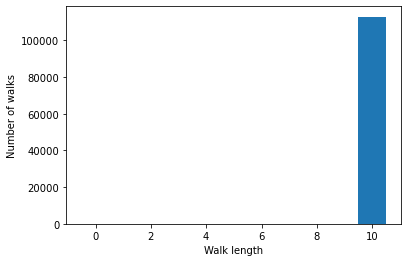

In [10]:
plot_walk_length_dist(h_walks_undirected)

Since these walks are on an undirected graph, it might be informative to look at how many unique vertexes we visit in each walk.

Number of walks: 112940
Number of walks by number of unique nodes visited:
2 : 34, 3 : 136, 4 : 538, 5 : 2267, 6 : 18130, 7 : 30020, 8 : 36614, 9 : 20961, 10 : 4240


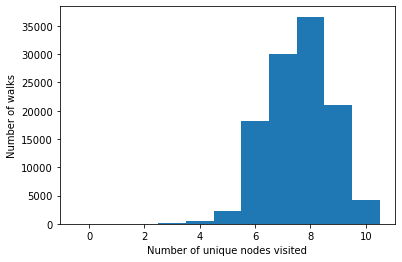

In [13]:
plot_distinct_nodes_in_walks(h_walks_undirected)

**We'll use the undirected representation's h-path walks.**  
Adding them to the list of paths that will later be fed to a skip-gram model.

In [14]:
walks = h_walks_undirected

And, here is what an example of a walk looks like:

In [15]:
", ".join(walks[0])

'Q1000597, Q67574558, Q1000597, Q145, Q6923815, Q145, Q27, Q602358, Q17, Q71699'

### 3. Let's see what embeddings we learn if we only use this feature
Use Skip-Gram model to learn representations for the entities

In [16]:
model = Word2Vec(walks, size=representation_size, window=window_size, min_count=0, sg=1, hs=1,
                 workers=workers)
model.wv.save("{}/entity_embeddings.kv".format(output_dir))

### Evaluate the embeddings
We want similar entities to have more similar embeddings. For the purpose of profiling entities of a desired type, we are specifically interested in similar entities *within a type* having more similar embeddings. I.e. if we look at the embeddings of the various beers we have, do the ones with more similar embeddings have more in common? We'll investigate using cosine similarity.

Let's compare entities of different types. We would expect a sovereign state and a beer to be less similar than two sovereign states.

In [17]:
print("Vergina Weiss and Cape Verde: {:.2f}".format(model.wv.similarity('Q93559285','Q1011')))
print("Ireland and United Kingdom: {:.2f}".format(model.wv.similarity('Q27','Q145')))

Vergina Weiss and Cape Verde: 0.09
Ireland and United Kingdom: 0.54


Now let's compare various things that are more directly related to beer

In [18]:
print("beer and alcoholic beverage: {:.2f}".format(model.wv.similarity('Q44','Q154')))
print("beer and Macedonian Thrace Brewery (instance of both beer and brewery): {:.2f}".format(model.wv.similarity('Q44','Q12877510')))
print("beer and Vergina Alcohol Free (instance of beer): {:.2f}".format(model.wv.similarity('Q44','Q97412285')))
print("beer and Vergina Weiss (instance of beer): {:.2f}".format(model.wv.similarity('Q44','Q93559285')))
print("Vergina Alcohol Free and Vergina Weiss: {:.2f}".format(model.wv.similarity('Q97412285','Q93559285')))

beer and alcoholic beverage: 0.65
beer and Macedonian Thrace Brewery (instance of both beer and brewery): 0.62
beer and Vergina Alcohol Free (instance of beer): 0.70
beer and Vergina Weiss (instance of beer): 0.67
Vergina Alcohol Free and Vergina Weiss: 0.91


Finally, we can look at how similar each beer is to eachother (since we have very few of them)

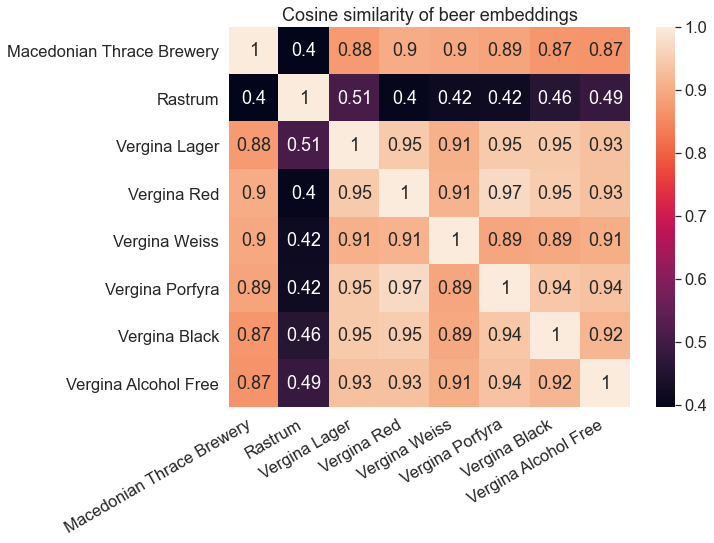

In [20]:
beer_vecs = model.wv['Q12877510', 'Q61976614', 'Q93552342', 'Q93557205', 'Q93559285', 'Q93558270', 'Q93560567', 'Q97412285']
similarity_mat = [model.wv.cosine_similarities(beer, beer_vecs) for beer in beer_vecs]
mask = np.zeros_like(similarity_mat)
mask[np.triu_indices_from(mask)] = True
labels = ['Macedonian Thrace Brewery', 'Rastrum', 'Vergina Lager', 'Vergina Red', 'Vergina Weiss', 'Vergina Porfyra', 'Vergina Black', 'Vergina Alcohol Free']
# Could mask to only show the lower triangle, but I think this is actually easier to read without the mask
fig, ax = plt.subplots(figsize=(9,7))
sns.set(font_scale=1.5)
sns.heatmap(similarity_mat, ax=ax, xticklabels=labels, yticklabels=labels, annot=True)
plt.xticks(rotation=30, horizontalalignment='right')
plt.title("Cosine similarity of beer embeddings")
plt.show()

The beer called 'Rastrum' seems to be an outlier. Searching for it online gives few results related to beer. Looking at similarities without this beer so we can more easily see how the others compare

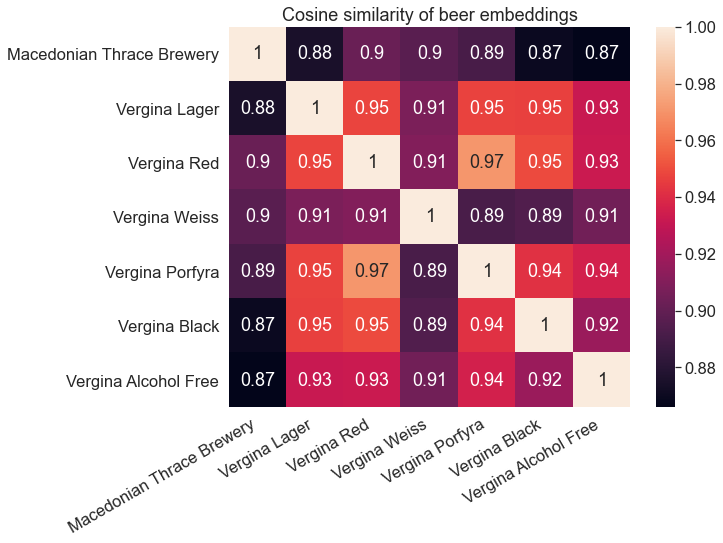

In [21]:
beer_vecs = model.wv['Q12877510', 'Q93552342', 'Q93557205', 'Q93559285', 'Q93558270', 'Q93560567', 'Q97412285']
similarity_mat = [model.wv.cosine_similarities(beer, beer_vecs) for beer in beer_vecs]
mask = np.zeros_like(similarity_mat)
mask[np.triu_indices_from(mask)] = True
labels = ['Macedonian Thrace Brewery', 'Vergina Lager', 'Vergina Red', 'Vergina Weiss', 'Vergina Porfyra', 'Vergina Black', 'Vergina Alcohol Free']
# Could mask to only show the lower triangle, but I think this is actually easier to read without the mask
fig, ax = plt.subplots(figsize=(9,7))
sns.set(font_scale=1.5)
sns.heatmap(similarity_mat, ax=ax, xticklabels=labels, yticklabels=labels, annot=True)
plt.xticks(rotation=30, horizontalalignment='right')
plt.title("Cosine similarity of beer embeddings")
plt.show()